In [1]:
import matplotlib.pyplot as plt
import logging
import numpy as np
import pandas as pd
import os
import time
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Flatten, Concatenate, Dropout, SimpleRNN
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from IPython.display import display
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')


/Users/admin/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
## ENABLE GPU Acceleration on M2
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2.12.0
Num GPUs Available:  1


# Constants

In [3]:
rolling_window = 10

dfs_cats = ['reb', 'pts', 'ast', 'stl', 'blk', 'tov']
same_game_cols = ['minutes_played', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta', 'ft_pct', 'oreb',
                   'dreb', 'reb', 'ast', 'tov', 'stl', 'blk', 'blka', 'pf', 'pfd', 'pts', 'plus_minus',
                   'nba_fantasy_pts', 'dd2', 'td3', 'wnba_fantasy_pts', 'available_flag', 'e_off_rating', 'off_rating',
                   'sp_work_off_rating', 'e_def_rating', 'def_rating', 'sp_work_def_rating', 'e_net_rating',
                   'net_rating', 'sp_work_net_rating', 'ast_pct', 'ast_to', 'ast_ratio', 'oreb_pct', 'dreb_pct',
                   'reb_pct', 'tm_tov_pct', 'e_tov_pct', 'efg_pct', 'ts_pct', 'usg_pct_x', 'e_usg_pct', 'e_pace',
                   'pace', 'pace_per40', 'sp_work_pace', 'pie', 'poss', 'fgm_pg', 'fga_pg', 'pct_fga_2pt',
                   'pct_fga_3pt', 'pct_pts_2pt', 'pct_pts_2pt_mr', 'pct_pts_3pt', 'pct_pts_fb', 'pct_pts_ft',
                   'pct_pts_off_tov', 'pct_pts_paint', 'pct_ast_2pm', 'pct_uast_2pm', 'pct_ast_3pm', 'pct_uast_3pm',
                   'pct_ast_fgm', 'pct_uast_fgm', 'pct_fgm', 'pct_fga', 'pct_fg3m', 'pct_fg3a', 'pct_ftm', 'pct_fta',
                   'pct_oreb', 'pct_dreb', 'pct_reb', 'pct_ast', 'pct_tov', 'pct_stl', 'pct_blk', 'pct_blka', 'pct_pf',
                   'pct_pfd', 'pct_pts', 'usage_rate', 'fp_draftkings', 'fp_fanduel',
                   'fp_yahoo']


In [4]:
def assign_league_weeks(df):
    df['week'] = df['game_date'].dt.isocalendar().week
    df['season_start'] = df.groupby('season_year')['game_date'].transform('min')
    df['season_week'] = ((df['game_date'] - df['season_start']).dt.days // 7) + 1
    df = df.drop(columns=['season_start', 'week'])
    df = df.rename(columns={'season_week': 'league_week'})
    return df

In [5]:
def rolling_train_test_rnn(X, y, df, num_weeks_for_training=4, time_steps=4, save_model=False, model_dir='models'):
    os.makedirs(model_dir, exist_ok=True)

    # Initialize lists to store predictions and true values
    all_predictions = []
    all_true_values = []
    all_game_ids = []
    all_game_dates = []
    all_player_ids = []
    all_fanduel_salaries = []
    all_draftkings_salaries = []
    all_yahoo_salaries = []
    all_fanduel_positions = []
    all_draftkings_positions = []
    all_yahoo_positions = []

    scaler = MinMaxScaler(feature_range=(0, 1))
    unique_weeks = df['league_week'].unique()

    for current_week in unique_weeks:
        start_week = current_week - num_weeks_for_training
        training_weeks = list(range(start_week, current_week))

        # Select training data (previous 4 weeks)
        X_train = X[X['league_week'].isin(training_weeks)]
        y_train = y.loc[X_train.index]

        # Select test data (current week)
        X_test = X[X['league_week'] == current_week]
        y_test = y.loc[X_test.index]

        if X_train.empty or X_test.empty:
            continue

        identifying_test_data = X_test[['player_name', 'game_date', 'game_id']]
        X_train = X_train.drop(columns=['game_date', 'game_id'])
        X_test = X_test.drop(columns=['game_date', 'game_id'])

        # Scale data
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Create sequences for training
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
        X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

        # Build and train the RNN model
        model = build_rnn_model((X_train_seq.shape[1], X_train_seq.shape[2]))
        model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=0)

        # Make predictions
        y_pred = model.predict(X_test_seq)

        # Store the predictions and true values
        all_predictions.extend(y_pred.flatten())
        all_true_values.extend(y_test_seq)
        all_game_ids.extend(list(identifying_test_data['game_id'])[time_steps:])
        all_game_dates.extend(list(identifying_test_data['game_date'])[time_steps:])
        all_player_ids.extend(list(identifying_test_data['player_name'])[time_steps:])
        all_fanduel_salaries.extend(X_test['salary-draftkings'].values[time_steps:])
        all_draftkings_salaries.extend(X_test['salary-draftkings'].values[time_steps:])
        all_yahoo_salaries.extend(X_test['salary-yahoo'].values[time_steps:])
        all_fanduel_positions.extend(X_test['pos-draftkings'].values[time_steps:])
        all_draftkings_positions.extend(X_test['pos-draftkings'].values[time_steps:])
        all_yahoo_positions.extend(X_test['pos-yahoo'].values[time_steps:])

        if save_model:
            model_filename = f'{model_dir}/rnn_model_week_{current_week}_trained_on_{start_week}_to_{current_week - 1}.h5'
            model.save(model_filename)

        mse = mean_squared_error(y_test_seq, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_seq, y_pred)

        print(f'Training weeks: {training_weeks}')
        print(f'Test week: {current_week}')
        print(f'Mean Squared Error (MSE): {mse:.2f}')
        print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
        print(f'R-squared (R²): {r2:.2f}')
        print('')

    results_df = pd.DataFrame({
        'player_name': all_player_ids,
        'game_id': all_game_ids,
        'game_date': all_game_dates,
        'y': all_true_values,
        'y_pred': all_predictions,
        'fanduel_salary': all_fanduel_salaries,
        'draftkings_salary': all_draftkings_salaries,
        'yahoo_salary': all_yahoo_salaries,
        'fanduel_position': all_fanduel_positions,
        'draftkings_position': all_draftkings_positions,
        'yahoo_position': all_yahoo_positions,
    })

    return results_df


In [6]:
def calculate_fp_fanduel(row, pred_mode=False):
    pred = '_pred' if pred_mode else ''
    return (row[f'pts{pred}'] +
            row[f'reb{pred}'] * 1.2 +
            row[f'ast{pred}'] * 1.5 +
            row[f'stl{pred}'] * 3 +
            row[f'blk{pred}'] * 3 -
            row[f'tov{pred}'] * 1)


def calculate_fp_yahoo(row, pred_mode=False):
    pred = '_pred' if pred_mode else ''
    return (row[f'pts{pred}'] +
            row[f'reb{pred}'] * 1.2 +
            row[f'ast{pred}'] * 1.5 +
            row[f'stl{pred}'] * 3 +
            row[f'blk{pred}'] * 3 -
            row[f'tov{pred}'] * 1)


def calculate_fp_draftkings(row, pred_mode=False):
    pred = '_pred' if pred_mode else ''
    fp = (row[f'pts{pred}'] +
          row[f'reb{pred}'] * 1.25 +
          row[f'ast{pred}'] * 1.5 +
          row[f'stl{pred}'] * 2 +
          row[f'blk{pred}'] * 2 -
          row[f'tov{pred}'] * 0.5)

    # Calculate Double-Double and Triple-Double bonuses
    stats = [row[f'pts{pred}'], row[f'reb{pred}'], row[f'ast{pred}'], row[f'stl{pred}'], row[f'blk{pred}']]
    double_double = sum([1 for stat in stats if stat >= 10]) >= 2
    triple_double = sum([1 for stat in stats if stat >= 10]) >= 3

    if double_double:
        fp += 1.5
    if triple_double:
        fp += 3

    return fp

def clean_numeric_columns(df, columns):
    """
    Convert columns to numeric, forcing errors to NaN, and handle specific non-numeric values.
    """
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert non-numeric to NaN
    return df

def add_time_dependent_features(df, rolling_window):
    for col in same_game_cols:
        logging.info(f"Adding features to {col}")
        gb = df.groupby('player_name')[col]
        df[f'{col}_rolling_{rolling_window}_day_avg'] = gb.transform(
            lambda x: x.rolling(rolling_window, min_periods=1).mean())
        df[f'{col}_rolling_{rolling_window}_day_std'] = gb.transform(
            lambda x: x.rolling(rolling_window, min_periods=1).std())
        df[f'{col}_lag_1'] = gb.shift(1)
        df[f'{col}_lag_2'] = gb.shift(2)
        df[f'{col}_lag_3'] = gb.shift(3)
        df[f'{col}_diff_1'] = gb.diff(1)
        df[f'{col}_diff_2'] = gb.diff(2)
        df[f'{col}_diff_3'] = gb.diff(3)
    return df


# Load

In [8]:
season = '2022-23'
path = f'data/merged_gamelogs_salaries_{season}.csv'
df = pd.read_csv(path)
df = df.drop('Unnamed: 0', axis=1)


<Axes: >

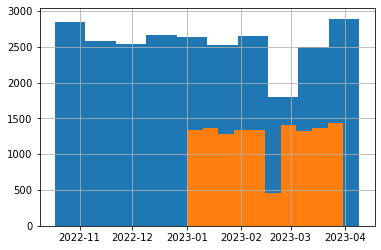

In [9]:
df['game_date'] = pd.to_datetime(df['game_date'])
df['game_date'].hist()
df = add_time_dependent_features(df, rolling_window=10)
df = clean_numeric_columns(df, same_game_cols)

dff = df[(df['game_date'] >= '2023-01-01') & (df['game_date'] < '2023-04-01')]
dff['game_date'].hist()

In [10]:
dff['salary-yahoo'].quantile(0.5)

12.0

In [11]:
dff = dff[(dff['salary-draftkings'] > dff['salary-draftkings'].quantile(0.5)) & (dff['salary-fanduel'] > dff['salary-fanduel'].quantile(0.5)) & (dff['salary-yahoo'] > dff['salary-yahoo'].quantile(0.5))]

In [12]:
dff['game_date'] = pd.to_datetime(dff['game_date'])
metadata = dff[['game_date', 'player_name']].copy()
dff = clean_numeric_columns(dff, same_game_cols)
dff['days_since_start'] = (dff['game_date'] - dff['game_date'].min()).dt.days  # Convert to days
dff = dff.drop(columns=['game_date'])  # Drop the original 'game_date' column after conversion

## Missing values

In [13]:
len(dff)

5378

In [14]:
dff.isna().sum().sort_values(ascending=False).head(30)

e_off_rating_diff_3      120
e_usg_pct_diff_3         120
fga_lag_3                120
e_usg_pct_lag_3          120
fga_diff_3               120
e_def_rating_diff_3      120
usg_pct_x_diff_3         120
stl_diff_3               120
usg_pct_x_lag_3          120
fg_pct_lag_3             120
pct_fg3a_lag_3           120
pct_fga_lag_3            120
fg_pct_diff_3            120
pct_oreb_diff_3          120
ts_pct_diff_3            120
nba_fantasy_pts_lag_3    120
ts_pct_lag_3             120
fg3m_lag_3               120
efg_pct_diff_3           120
fg3m_diff_3              120
stl_lag_3                120
efg_pct_lag_3            120
def_rating_lag_3         120
e_def_rating_lag_3       120
e_pace_lag_3             120
pct_reb_diff_3           120
fgm_diff_3               120
pct_reb_lag_3            120
pie_lag_3                120
blka_lag_3               120
dtype: int64

In [15]:
# prompt: show only rows and columns with missing values in dff

# Find rows and columns with missing values
rows_with_missing = dff[dff.isnull().any(axis=1)]
cols_with_missing = dff.columns[dff.isnull().any()]

# Show only rows and columns with missing values
dff_missing = dff.loc[dff.isnull().any(axis=1), dff.isnull().any()]

In [16]:
dff_missing

,minutes_played_rolling_10_day_std,minutes_played_lag_1,minutes_played_lag_2,minutes_played_lag_3,minutes_played_diff_1,minutes_played_diff_2,minutes_played_diff_3,fgm_rolling_10_day_std,fgm_lag_1,fgm_lag_2,...,fp_fanduel_diff_1,fp_fanduel_diff_2,fp_fanduel_diff_3,fp_yahoo_rolling_10_day_std,fp_yahoo_lag_1,fp_yahoo_lag_2,fp_yahoo_lag_3,fp_yahoo_diff_1,fp_yahoo_diff_2,fp_yahoo_diff_3
1476,3.859363,35.716667,37.276667,NaN,-5.766667,-7.326667,NaN,2.645751,11.0,7.0,...,-26.5,-3.0,NaN,14.511490,48.4,24.9,NaN,-26.5,-3.0,NaN
1492,1.850263,34.416667,NaN,NaN,-2.616667,NaN,NaN,0.707107,3.0,NaN,...,-5.9,NaN,NaN,4.171930,24.1,NaN,NaN,-5.9,NaN,NaN
1506,3.476608,38.916667,NaN,NaN,-4.916667,NaN,NaN,4.949747,12.0,NaN,...,-21.3,NaN,NaN,15.061374,41.7,NaN,NaN,-21.3,NaN,NaN
1546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1626,5.177203,19.266667,22.133333,NaN,10.050000,7.183333,NaN,1.732051,7.0,7.0,...,18.9,-3.2,NaN,11.943338,23.9,46.0,NaN,18.9,-3.2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11428,3.401626,25.798333,32.550000,NaN,2.651667,-4.100000,NaN,1.732051,6.0,3.0,...,-8.4,-5.2,NaN,4.239497,41.4,38.2,NaN,-8.4,-5.2,NaN
12191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12695,9.958421,29.366667,NaN,NaN,-14.083333,NaN,NaN,2.828427,6.0,NaN,...,-16.8,NaN,NaN,11.879394,29.4,NaN,NaN,-16.8,NaN,NaN
12970,7.046282,15.283333,29.366667,NaN,6.600000,-7.483333,NaN,2.309401,2.0,6.0,...,3.3,-13.5,NaN,8.901124,12.6,29.4,NaN,3.3,-13.5,NaN


In [17]:
rows_with_missing['days_since_start'].value_counts()

days_since_start
89    19
75     8
82     7
84     6
80     6
87     5
86     5
81     5
77     5
88     5
85     4
43     3
53     3
59     3
45     3
76     3
78     3
79     3
70     2
55     2
72     2
7      1
9      1
12     1
17     1
19     1
21     1
38     1
41     1
64     1
54     1
57     1
61     1
62     1
63     1
66     1
67     1
68     1
1      1
Name: count, dtype: int64

Honestly, I have no idea what causes these missing values, so I'm just dropping them

In [18]:
print(len(dff))
dff = dff.dropna()
print(len(dff))


5378
5258


In [19]:
categorical_cols = [col for col in dff.columns if dff[col].dtype == 'object']
dff_encoded = pd.get_dummies(dff, columns=categorical_cols)

In [20]:
dff_encoded

,player_id,team_id,game_id,minutes_played,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,...,pos-fanduel_SF/PF,pos-fanduel_SF/SG,pos-fanduel_SG,pos-fanduel_SG/PG,pos-fanduel_SG/SF,pos-yahoo_C,pos-yahoo_PF,pos-yahoo_PG,pos-yahoo_SF,pos-yahoo_SG
1474,203991,1610612737,22201153,19.866667,3,6,0.500,0,0,0.000,...,False,False,False,False,False,True,False,False,False,False
1481,202687,1610612756,22201160,19.700000,3,8,0.375,0,0,0.000,...,False,False,False,False,False,True,False,False,False,False
1482,1631114,1610612760,22201149,29.505000,6,10,0.600,0,3,0.000,...,False,True,False,False,False,False,True,False,False,False
1483,1628976,1610612753,22201151,26.333333,5,11,0.455,1,5,0.200,...,False,False,False,False,False,True,False,False,False,False
1488,203497,1610612750,22201157,31.100000,6,9,0.667,0,0,0.000,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14072,203999,1610612743,22200549,32.033333,10,13,0.769,2,2,1.000,...,False,False,False,False,False,True,False,False,False,False
14074,1627763,1610612738,22200549,19.583333,1,6,0.167,0,3,0.000,...,False,False,False,False,False,False,False,False,False,True
14078,201143,1610612738,22200549,30.100000,3,10,0.300,2,6,0.333,...,False,False,False,False,False,True,False,False,False,False
14088,1629008,1610612743,22200549,32.600000,7,13,0.538,3,7,0.429,...,False,False,False,False,False,False,False,False,True,False


## Model Training Fixed

In [21]:
def create_sequences_with_rolling_window(data, metadata, sequence_length, target_column, rolling_step=1):
    """
    Create sequences and labels for rolling window time series prediction.

    Parameters:
    - data: The input DataFrame (features).
    - metadata: DataFrame with 'player_name' and 'game_date' for tracking.
    - sequence_length: Number of previous time steps to include in each sequence.
    - target_column: The column that contains the target values ('fp_draftkings', 'fp_fanduel', or 'fp_yahoo').
    - rolling_step: How much the window moves after each iteration (default is 1 day).

    Returns:
    - sequences: List of input sequences (X).
    - labels: List of labels (y).
    - metadata_seq: List of metadata (game_date, player_name).
    """
    sequences = []
    labels = []
    metadata_seq = []

    drop_cols = ['fp_draftkings', 'fp_fanduel', 'fp_yahoo']  # Drop target columns to avoid leakage

    for i in tqdm(range(sequence_length, len(data) - rolling_step), desc="Creating Sequences"):
        # Sequence of past game data
        sequence = data.iloc[i - sequence_length:i].drop(columns=drop_cols).values
        label = data.iloc[i][target_column]

        # Append the corresponding metadata for the current day (label) to keep track of which player/date it is
        metadata_seq.append(metadata.iloc[i])

        sequences.append(sequence)
        labels.append(label)

    return np.array(sequences), np.array(labels), pd.DataFrame(metadata_seq)


In [22]:
X, y, metadata_seq = create_sequences_with_rolling_window(dff_encoded, metadata, sequence_length=10, target_column='fp_draftkings')

Creating Sequences: 100%|██████████| 5247/5247 [00:07<00:00, 681.15it/s]


In [23]:
def train_with_rolling_window(data, metadata, target_column, sequence_length=10, epochs=5):
    """
    Train the model using a rolling window approach, making predictions for each day
    after training on the previous 'sequence_length' days.

    Parameters:
    - data: The input DataFrame (encoded features).
    - metadata: DataFrame with 'player_name' and 'game_date' for tracking.
    - target_column: The column to predict (e.g., 'fp_draftkings', 'fp_fanduel', 'fp_yahoo').
    - sequence_length: The number of previous days to use for training.
    - epochs: Number of epochs to train the model on each window.

    Returns:
    - results_df: DataFrame with game_date, player_name, y_test, and y_pred.
    - losses_df: DataFrame with training and validation loss for each epoch.
    """
    X, y, metadata_seq = create_sequences_with_rolling_window(data, metadata, sequence_length, target_column)

    predictions = []
    actuals = []
    metadata_test = []

    # Lists to store losses for each epoch
    all_train_losses = []
    all_val_losses = []

    for current_day in range(sequence_length, len(X)):
        # Define the current rolling window (training on the past 'sequence_length' days)
        X_train_window = X[current_day - sequence_length:current_day]
        y_train_window = y[current_day - sequence_length:current_day]

        # Select the test data (the current day)
        X_test = X[current_day].reshape(1, -1, X.shape[2])
        y_test = y[current_day]

        # Scale the data within this window
        scaler = StandardScaler()
        X_train_window_flat = X_train_window.reshape(-1, X_train_window.shape[-1])
        X_train_window_scaled = scaler.fit_transform(X_train_window_flat).reshape(X_train_window.shape)

        X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

        # Define the LSTM model
        model = Sequential()
        model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_window_scaled.shape[1], X_train_window_scaled.shape[2])))
        model.add(Dropout(0.3))
        model.add(LSTM(units=100, return_sequences=False))
        model.add(Dropout(0.3))
        model.add(Dense(units=1))

        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train the model on the current window and get the history
        history = model.fit(X_train_window_scaled, y_train_window, epochs=epochs, batch_size=32,
                            validation_data=(X_test_scaled, np.array([y_test])), verbose=0)

        # Store training and validation loss for each epoch
        all_train_losses.extend(history.history['loss'])
        all_val_losses.extend(history.history['val_loss'])

        # Predict on the test data (current day)
        y_pred = model.predict(X_test_scaled)

        # Store predictions and actuals
        predictions.append(y_pred.flatten())
        actuals.append(y_test)

        # Save metadata for this test instance (game_date, player_name)
        metadata_test.append(metadata_seq.iloc[current_day])

    # Create a DataFrame with results
    results_df = pd.DataFrame(metadata_test)
    results_df['y_test'] = actuals
    results_df['y_pred'] = predictions

    # Create a DataFrame with loss history
    losses_df = pd.DataFrame({
        'train_loss': all_train_losses,
        'val_loss': all_val_losses
    })

    # Evaluation metrics
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'R-squared (R²): {r2}')

    return results_df, losses_df


# RNN Model Runs on Each Platform:

In [ ]:
# Train the model with rolling window and retrieve losses
results_df, losses_df = train_with_rolling_window(dff_encoded, metadata, target_column='fp_draftkings', sequence_length=10, epochs=5)


# # previous model training runs to iterate thru all 3 platforms >>
# # List to store results
# results = []
#
# # Platforms to iterate over
# platforms = ['draftkings', 'fanduel', 'yahoo']
#
# for platform in platforms:
#     result = train_and_evaluate_model(df_encoded, platform, sequence_length=10, epochs=50)
#     results.append(result)
#
# # Convert results to a DataFrame
# results_df = pd.DataFrame(results)


Creating Sequences: 100%|██████████| 5247/5247 [00:12<00:00, 428.64it/s]
2024-10-29 15:44:07.521732: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 1s 651ms/step


1/1 [==============================] - 1s 688ms/step


1/1 [==============================] - 3s 3s/step


In [1]:
# Print the first few rows of results and loss history
print(results_df.head())
print(losses_df.head())

# Plot the training and validation losses over epochs
import matplotlib.pyplot as plt
plt.plot(losses_df['train_loss'], label='Training Loss')
plt.plot(losses_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


NameError: name 'results_df' is not defined